In [100]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize

# Load data from Chapter 4

In [101]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ch4.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0, beta0 = np.load(f)

# Figure 5.1

Probabiliy < 0.300 = 0.18


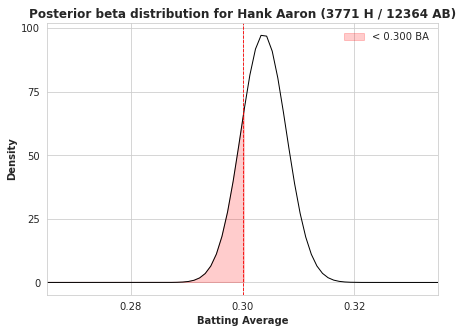

In [102]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Make distributions for prior and each player
    x = np.linspace(0,1,1000)

    aa,bb = bd.loc[bd.Name.isin(["Hank Aaron"]),["alpha1","beta1"]].to_numpy()[0]
    habeta = stats.beta.pdf(x,aa,bb)
    ax.plot(x,habeta,color='k',lw=1)
    x_idx = np.where(np.less_equal(x,0.3))[0]
    ax.fill_between(x[x_idx+1],habeta[x_idx+1],len(x_idx)*[0],color='r',alpha=0.2,label="< 0.300 BA")
    ax.axvline(x=0.3,color='r',linestyle='--',lw=.85)
    ax.set_xlim(0.265,0.335)

    # Add legend and clean up
    ax.legend(frameon=False)
    ax.set_title("Posterior beta distribution for Hank Aaron (3771 H / 12364 AB)",fontweight='bold')
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks([.28,.3, .32])
    ax.set_yticks([0,25,50,75,100])

    print("Probabiliy < 0.300 = {}".format(round(stats.beta.cdf(0.3,aa,bb),2)))

Calculate the Posterior Error Probability (PEP) for each player.

In [103]:
def calculate_PEP(data,q=0.3):
        # Get explicit credible intervals
        data["PEP"] = stats.beta.cdf(q,data["alpha1"],data["beta1"])
        return data

bd = bd.apply(calculate_PEP,axis=1)

# Figure 5.2

Histogram of posterior error probability (PEP) values across all players.

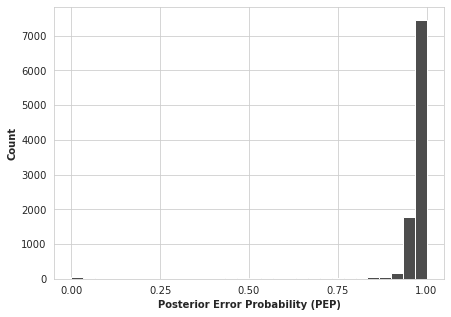

In [104]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.histplot(data=bd,x="PEP",bins=30,color=tuple(3*[0.3]),alpha=1)
    ax.set_xticks(np.linspace(0,1,5))
    ax.set_xlabel("Posterior Error Probability (PEP)",fontweight="bold")
    ax.set_ylabel("Count",fontweight="bold")

# Figure 5.3
Relationship of the shrunken batting average and the posterior error probability of whether the player’s batting average is > .3. The value .300 is marked as a dashed red line.

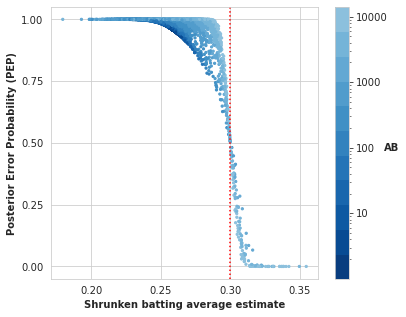

In [105]:
import matplotlib as mpl

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot()
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])
    # Plot scatter 
    splot = ax.scatter(bd["eb estimate Avg"],bd["PEP"],c=bd["AB"],cmap=cmap,norm=mpl.colors.LogNorm(),s=5)
    # Plot pure eb estimate
    ax.axvline(x=0.3,color='r',linestyle=':')
    # Clean up
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot,ticks=cbar_ticks)
    cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("AB",rotation=0,fontweight="bold")
    ax.set_xticks([0.2,0.25,0.3,0.35])
    ax.set_yticks(np.linspace(0,1,5))
    ax.set_xlabel("Shrunken batting average estimate",fontweight="bold")
    ax.set_ylabel("Posterior Error Probability (PEP)",fontweight="bold")

Lets look at the 10 players with highest PEP

In [106]:
bd.sort_values(by="PEP").loc[:,["Name","AB","H","eb estimate Avg", "PEP"]].head(10)

,Name,AB,H,eb estimate Avg,PEP
4089,Rogers Hornsby,8173,2930,0.354518,1.599453e-27
2194,Ed Delahanty,7510,2597,0.342047,4.897725e-16
4578,Willie Keeler,8591,2932,0.338158,3.618536e-15
4275,Shoeless joe Jackson,4981,1772,0.349565,3.699207e-15
4892,Nap Lajoie,9590,3243,0.335458,1.182739e-14
3534,Tony Gwynn,9288,3141,0.335387,3.264105e-14
3804,Harry Heilmann,7787,2660,0.338143,5.905187e-14
3120,Lou Gehrig,8001,2721,0.336782,2.079438e-13
3605,Billy Hamilton,6283,2164,0.340039,1.057724e-12
1706,Eddie Collins,9949,3315,0.330754,7.711440e-12


In [107]:
bd.sort_values(by="PEP").loc[:,["Name","AB","H","eb estimate Avg", "PEP"]].reset_index().iloc[89:99,:]

,index,Name,AB,H,eb estimate Avg,PEP
89,5316,Denny Lyons,4300,1334,0.306518,0.167725
90,0,Hank Aaron,12364,3771,0.303783,0.176985
91,9683,Taffy Wright,3583,1115,0.306715,0.180922
92,8554,John Stone,4494,1391,0.306008,0.182400
93,6173,Ed Morgan,2810,879,0.307060,0.195332
94,1177,George Burns,6573,2018,0.304680,0.199141
95,349,Home run Baker,5984,1838,0.304594,0.213959
96,5588,Joe Mauer,6930,2123,0.304161,0.220597
97,4594,George Kell,6702,2054,0.304211,0.221556
98,9182,Joe Vosmik,5472,1682,0.304586,0.224122


Lets look at the top 100 players. The PEP is the probability that each player is a false positive. We can just add up the PEP for the top players to get the expected value of false positives

In [131]:
bd_sorted = bd.sort_values(by="PEP").reset_index()

EV_FP = bd_sorted.iloc[0:99,:].PEP.sum()
print("Expected number of false positives: {:.2f}".format(EV_FP))

MEAN_PEP = bd_sorted.iloc[0:99,:].PEP.mean()
print("Mean PEP: {:.4f}".format(MEAN_PEP))

Expected number of false positives: 5.46
Mean PEP: 0.0552


In [132]:

print("False discovery rate for top 200: {:.3f}".format(bd_sorted.iloc[0:199,:].PEP.mean()))

print("False discovery rate for top 50: {:.5f}".format(bd_sorted.iloc[0:49,:].PEP.mean()))


False discovery rate for top 200: 0.259
False discovery rate for top 50: 0.00185


# Calculate Q value
The q value is the cumulative mean of all the (sorted) posterior error probabilities

In [134]:
bd_sorted["q_value"] = bd_sorted.PEP.expanding().mean()

The q-value allows us to say: “to control the FDR at X%, collect only hypotheses where q < X”

In [140]:
# Filter out at 5%
print("A threshold of 5% results in {} players.".format(len(bd_sorted.loc[bd_sorted.q_value < 0.05,"Name"])))
bd_sorted.loc[bd_sorted.q_value < 0.05,"Name"]

A threshold of 5% results in 96 players.


0           Rogers Hornsby
1             Ed Delahanty
2            Willie Keeler
3     Shoeless joe Jackson
4               Nap Lajoie
              ...         
91            Taffy Wright
92              John Stone
93               Ed Morgan
94            George Burns
95          Home run Baker
Name: Name, Length: 96, dtype: object

In [139]:
# Filter out at 1%
print("A threshold of 1% results in {} players.".format(len(bd_sorted.loc[bd_sorted.q_value < 0.01,"Name"])))
bd_sorted.loc[bd_sorted.q_value < 0.01,"Name"]

A threshold of 1% results in 62 players.


0           Rogers Hornsby
1             Ed Delahanty
2            Willie Keeler
3     Shoeless joe Jackson
4               Nap Lajoie
              ...         
57             Johnny Mize
58            Cecil Travis
59             Elmer Flick
60            Sam Crawford
61               Bibb Falk
Name: Name, Length: 62, dtype: object

# Figure 5.4
Comparison of the q-value threshold (for finding players with an average above .300) and the number of players that would be included at that threshold.

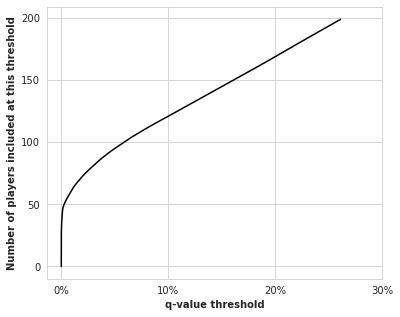

In [169]:
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot()
    ax.plot(bd_sorted.iloc[0:200,:].q_value,bd_sorted.iloc[0:200,:].index.tolist(),color='k')
    # clean  up
    xticks = [0,.1,.2,.3]
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(round(x*100))+"%" for x in xticks])
    ax.set_yticks(np.linspace(0,200,5))
    ax.set_xlabel("q-value threshold",fontweight="bold")
    ax.set_ylabel("Number of players included at this threshold",fontweight="bold")